<a href="https://colab.research.google.com/github/roshinisanikop/Mitigating_Bias_in_Facial_Recognition_using_Seldonian_Framework/blob/main/Working_Seldonian_Model_Facial_recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install --upgrade seldonian-engine

In [2]:
# Comment the following if you are running your code locally

# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs682/assignments/assignment1++++++++++++

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt
import numpy as np

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [4]:
! pip install datasets

## Data Preparation

In [5]:
from datasets import load_dataset
import pandas as pd

def load_fair_dataset_combined():
    # Load the dataset
    ds = load_dataset("HuggingFaceM4/FairFace", "0.25")

    # Convert train and test datasets to Pandas DataFrames
    df_train = ds['train'].to_pandas()
    df_test = ds['validation'].to_pandas()

    # Combine train and test data into a single DataFrame
    combined_df = pd.concat([df_train, df_test], ignore_index=True)

    # Return the combined DataFrame
    return df_train.iloc[:, 0:4], df_test.iloc[:, 0:4], combined_df.iloc[:, 0:4]

# Load and combine the dataset
df_train, df_test, combined_df = load_fair_dataset_combined()
df_train, df_test, combined_df


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(                                                   image  age  gender  race
 0      {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    6       0     0
 1      {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    4       1     1
 2      {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    1       1     2
 3      {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    3       1     1
 4      {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    3       1     1
 ...                                                  ...  ...     ...   ...
 86739  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    3       0     1
 86740  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    2       0     1
 86741  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    8       1     1
 86742  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    2       1     2
 86743  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    5       0     3
 
 [86744 rows x 4 columns],
                                               

In [6]:
data_train = df_train.sample(n = len(df_train), random_state = 42).iloc[:len(df_train)]
data_test = df_test.sample(n = len(df_test), random_state = 42).iloc[:len(df_test)]

In [7]:
import numpy as np
from PIL import Image
import io
from seldonian.utils.io_utils import save_pickle

def process_rgb_image(image_dict):
    try:
        # Load image from bytes
        image_bytes = image_dict['bytes']
        image = Image.open(io.BytesIO(image_bytes))

        # Convert image to RGB to ensure 3 channels
        image = image.convert("RGB")

        # Resize to (48, 48)
        image = image.resize((48, 48))

        # Convert to NumPy array
        image_array = np.array(image, dtype=np.float32)

        # Normalize to [0, 1]
        image_array /= 255.0

        return image_array
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Process the images
print("Processing RGB images...")
data_train['pixels'] = data_train['image'].apply(process_rgb_image)
data_test['pixels'] = data_test['image'].apply(process_rgb_image)

Processing RGB images...


In [8]:
combined = pd.concat([data_train, data_test], ignore_index=True)

In [9]:
# Convert processed images to a NumPy array
print("Converting images to NumPy array...")
X = np.array(combined['pixels'].tolist())  # Shape: (num_samples, 48, 48, 3)

# Reshape to (num_samples, 3, 48, 48)
# images = X.transpose(0, 3, 1, 2)
images =  X.reshape(X.shape[0], 3, 48, 48)

Converting images to NumPy array...


In [10]:
labels  = combined['gender'].values

In [11]:
# One-hot encode the 'race' column
combined['caucasian'] = (combined['race'] == 3).astype(int)  # 1 if race is 3, else 0
combined['not_caucasian'] = (combined['race'] != 3).astype(int)  # 1 if race is 5, else 0

race_three = combined['caucasian'].values
race_five = combined['not_caucasian'].values

sensitive_attrs = np.hstack((race_three.reshape(-1,1),race_five.reshape(-1,1)))

Unique races: [4 1 2 5 0 3 6]
Unique ages: [3 4 2 1 6 8 5 0 7]


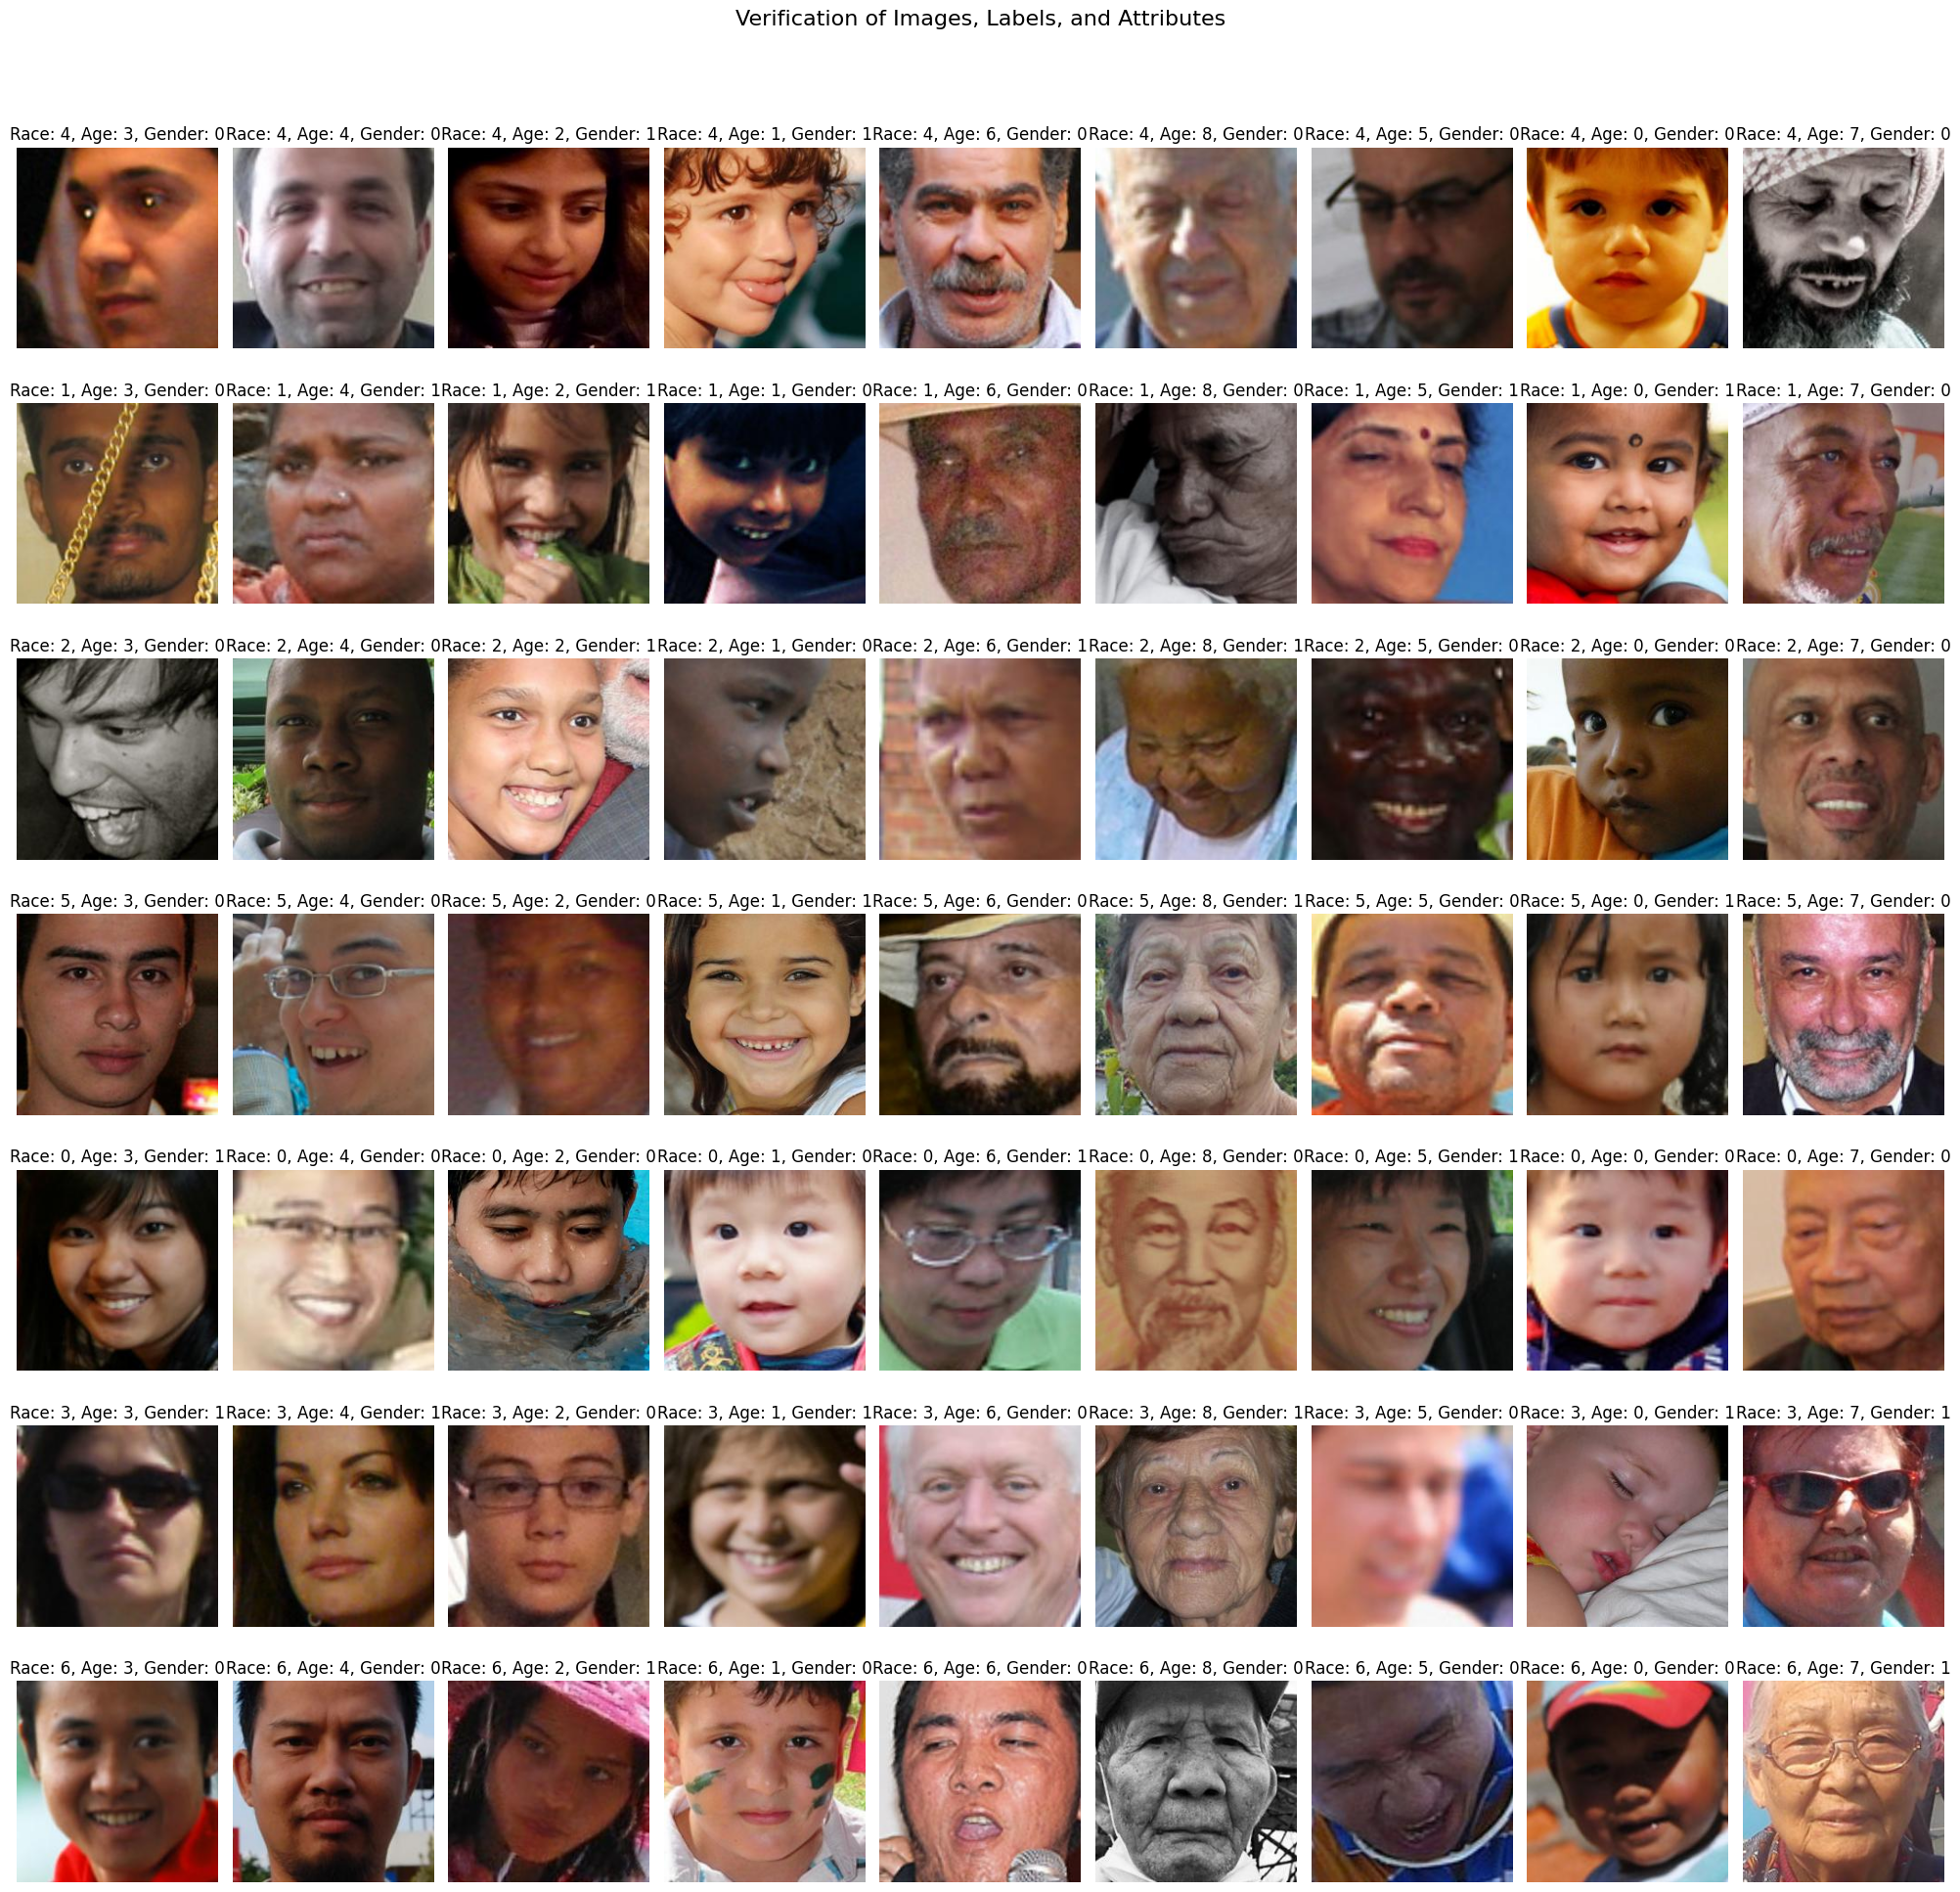

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import io

def verify_data(data):
    """
    Visualize one example for each combination of race and age values.
    Shows the image, race, age, and gender.

    :param data: DataFrame containing 'image', 'age', 'gender', and 'race' columns
    :type data: pd.DataFrame
    """
    unique_races = data['race'].unique()
    unique_ages = data['age'].unique()

    print("Unique races:", unique_races)
    print("Unique ages:", unique_ages)

    fig, axes = plt.subplots(len(unique_races), len(unique_ages), figsize=(20, 20))
    fig.suptitle("Verification of Images, Labels, and Attributes", fontsize=16)

    for i, race in enumerate(unique_races):
        for j, age in enumerate(unique_ages):
            # Filter data for the specific race and age
            filtered_data = data[(data['race'] == race) & (data['age'] == age)]
            if not filtered_data.empty:
                # Take the first example from the filtered data
                sample = filtered_data.iloc[0]
                image_bytes = sample['image']['bytes']
                image = Image.open(io.BytesIO(image_bytes))

                # Plot the image
                ax = axes[i, j]
                ax.imshow(image)
                ax.axis('off')

                # Add the metadata as title
                gender = sample['gender']
                ax.set_title(f"Race: {race}, Age: {age}, Gender: {gender}")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Example usage
verify_data(combined)


In [13]:
# Save to pickle files
savename_features = './drive/MyDrive/ColabNotebooks/682_project/features.pkl'
savename_labels = './drive/MyDrive/ColabNotebooks/682_project/labels.pkl'
savename_sensitive_attrs = './drive/MyDrive/ColabNotebooks/682_project/sensitive_attrs.pkl'

print("Saving features and labels...")
save_pickle(savename_features, images)
save_pickle(savename_labels, labels)
save_pickle(savename_sensitive_attrs, sensitive_attrs)

print("Processing complete.")

Saving features and labels...
Processing complete.


In [14]:
savename_features = './drive/MyDrive/ColabNotebooks/682_project/features.pkl'
savename_labels = './drive/MyDrive/ColabNotebooks/682_project/labels.pkl'
savename_sensitive_attrs = './drive/MyDrive/ColabNotebooks/682_project/sensitive_attrs.pkl'


## Running the Seldonian experiment

In [15]:
from seldonian.models.pytorch_model import SupervisedPytorchBaseModel
import torch.nn as nn
import torch

class FacialRecogCNNModel(nn.Module):
    def __init__(self):
        super(FacialRecogCNNModel, self).__init__()
        # Define all layers here
        self.cnn1=nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.cnn2=nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.cnn3=nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.cnn4=nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)

        self.relu=nn.ReLU()
        self.maxpool=nn.MaxPool2d(kernel_size=2)

        self.Batch1=nn.BatchNorm2d(16)
        self.Batch2=nn.BatchNorm2d(32)
        self.Batch3=nn.BatchNorm2d(64)
        self.Batch4=nn.BatchNorm2d(128)

        # Fully connected 1 (readout)
        self.fc1=nn.Linear(128 * 1 * 1, 128)
        self.fc2=nn.Linear(128,256)
        self.fc3=nn.Linear(256,2)
        self.softmax=nn.Softmax(dim=1)

    def forward(self, x):
        # Call all layers here. This does the forward pass.
        out=self.cnn1(x)
        out=self.relu(out)
        out=self.maxpool(out)
        out=self.Batch1(out)

        out=self.cnn2(out)
        out=self.relu(out)
        out=self.maxpool(out)
        out=self.Batch2(out)

        out=self.cnn3(out)
        out=self.relu(out)
        out=self.maxpool(out)
        out=self.Batch3(out)

        out=self.cnn4(out)
        out=self.relu(out)
        out=self.maxpool(out)
        out=self.Batch4(out)

        # Resize
        # Original size: (100, 32, 7, 7)
        # New out size: (100, 32*7*7)
        out=torch.flatten(out,start_dim=1)

        # Linear functions (readout)
        out=self.fc1(out)
        out=self.fc2(out)
        out=self.fc3(out)

        # Softmax to make probabilities
        out=self.softmax(out)[:,1]

        return out

class PytorchFacialRecog(SupervisedPytorchBaseModel):
    def __init__(self,device):
        """ Implements a CNN with PyTorch.
        CNN consists of four hidden layers followed
        by a linear + softmax output layer.

        Inputs are N,1,48,48 where N is the number of them,
        1 channel and 48x48 pixels.
        """
        super().__init__(device)

    def create_model(self,**kwargs):
        """ Create the pytorch model and return it
        """
        return FacialRecogCNNModel()

In [16]:
# Define parameters
device = 'cuda'  # or 'cuda' if using a GPU
num_classes = 2  # Example: 9 age categories

# Instantiate the model
model = PytorchFacialRecog(device=device)

# Create the CNN model
cnn_model = model.create_model()

# Print model architecture
print(cnn_model)


FacialRecogCNNModel(
  (cnn1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (cnn3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (cnn4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)


In [17]:
# !apt-get install git
# !git clone https://github.com/seldonian-toolkit/Engine.git "/content/drive/My Drive/ColabNotebooks/682_project/seldonian_toolkit"


In [18]:
from seldonian.spec import SupervisedSpec
from seldonian.dataset import SupervisedDataSet
from seldonian.utils.io_utils import load_pickle,save_pickle
from seldonian.models import objectives
from seldonian.seldonian_algorithm import SeldonianAlgorithm
from seldonian.parse_tree.parse_tree import (
    make_parse_trees_from_constraints)
import autograd.numpy as np
from types import SimpleNamespace

In [26]:
regime='supervised_learning'
sub_regime='classification'
# features = load_pickle(savename_features)
# labels = load_pickle(savename_labels)
# sensitive_attrs = load_pickle(savename_sensitive_attrs)

features = images
labels = labels
sensitive_attrs = sensitive_attrs

frac_data_in_safety = 0.5
sensitive_col_names = ['race_three','race_other']

meta_information = SimpleNamespace(
    feature_col_names=['image'],
    label_col_names=['gender'],
    sensitive_col_names=sensitive_col_names,
    sub_regime=sub_regime,
    regime=regime
)

print("Making SupervisedDataSet...")
dataset = SupervisedDataSet(
    features=features,
    labels=labels,
    sensitive_attrs=sensitive_attrs,
    num_datapoints= len(features),
    meta = meta_information)

constraint_strs = ['min((ACC | [race_three])/(ACC | [race_other]),(ACC | [race_other])/(ACC | [race_three])) >= 0.8']
deltas = [0.05]
print("Making parse trees for constraint(s):")
print(constraint_strs," with deltas: ", deltas)


parse_trees = make_parse_trees_from_constraints(
    constraint_strs,deltas,regime=regime,
    sub_regime=sub_regime,columns=sensitive_col_names)

initial_solution_fn = model.get_model_params

primary_objective_fn = objectives.binary_logistic_loss


Making SupervisedDataSet...
Making parse trees for constraint(s):
['min((ACC | [race_three])/(ACC | [race_other]),(ACC | [race_other])/(ACC | [race_three])) >= 0.8']  with deltas:  [0.05]


In [27]:

spec = SupervisedSpec(
    dataset=dataset,
    model=model,
    parse_trees=parse_trees,
    frac_data_in_safety=frac_data_in_safety,
    primary_objective=primary_objective_fn,
    use_builtin_primary_gradient_fn=False,
    sub_regime=sub_regime,
    initial_solution_fn=initial_solution_fn,
    optimization_technique='gradient_descent',
    optimizer='adam',
    optimization_hyperparams={
        'lambda_init'   : np.array([0.5]),
        'alpha_theta'   : 0.001,
        'alpha_lamb'    : 0.001,
        'beta_velocity' : 0.9,
        'beta_rmsprop'  : 0.95,
        'use_batches'   : True,
        'batch_size'    : 237,
        'n_epochs'      : 10,
        'gradient_library': "autograd",
        'hyper_search'  : None,
        'verbose'       : True,
    },

    batch_size_safety=2000
)
#save_pickle('./spec.pkl',spec,verbose=True)

In [28]:
SA = SeldonianAlgorithm(spec)
passed_safety,solution = SA.run(debug=True,write_cs_logfile=True)

if passed_safety:
    print("Passed safety test.")
else:
    print("Failed safety test")

Streaming output truncated to the last 5000 lines.
 -0.04124049] [0.4554541]

epoch,batch_i,overall_i,f,g,theta,lambda: 2 46 460 0.5541012306630863 [-0.15103373] [-0.04205803  0.06998973  0.16681775 ... -0.02010655 -0.0058411
 -0.04110446] [0.45530697]

epoch,batch_i,overall_i,f,g,theta,lambda: 2 47 461 0.5998806573356255 [-0.05551827] [-0.04205802  0.06998974  0.16681777 ... -0.02029271 -0.00584115
 -0.04093947] [0.45515594]

epoch,batch_i,overall_i,f,g,theta,lambda: 2 48 462 0.5559051904968823 [-0.1376577] [-0.04205802  0.06998975  0.16681777 ... -0.02044614 -0.00584118
 -0.04079268] [0.45510042]

epoch,batch_i,overall_i,f,g,theta,lambda: 2 49 463 0.5697249808203318 [-0.15710794] [-0.04205802  0.06998976  0.16681778 ... -0.02056756 -0.00584123
 -0.04062857] [0.45496276]

Epoch: 2, batch iteration 50
epoch,batch_i,overall_i,f,g,theta,lambda: 2 50 464 0.586973853998735 [-0.13655731] [-0.04205802  0.06998976  0.1668178  ... -0.02078963 -0.00584128
 -0.04044   ] [0.45480565]

epoch,batch

# New Section